In [0]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
df = spark.table("workspace.default.mental_health_social_media_dataset")
df.printSchema()

root
 |-- person_name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- gender: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- daily_screen_time_min: integer (nullable = true)
 |-- social_media_time_min: integer (nullable = true)
 |-- negative_interactions_count: integer (nullable = true)
 |-- positive_interactions_count: integer (nullable = true)
 |-- sleep_hours: double (nullable = true)
 |-- physical_activity_min: integer (nullable = true)
 |-- anxiety_level: integer (nullable = true)
 |-- stress_level: integer (nullable = true)
 |-- mood_level: integer (nullable = true)
 |-- mental_state: string (nullable = true)



In [0]:
gender_stress_level = df.groupBy("gender").agg(F.round(F.avg("stress_level"), 2).alias("avg_stress_level"))

display(gender_stress_level)

gender,avg_stress_level
Male,7.12
Female,7.1
Other,7.06


Minimalnie bardziej zestresowani są mężczyźni (średnia 7.12) w porównaniu do kobiet (7.10), jednak różnica jest marginalna (zaledwie 0.02 punktu).

In [0]:
correlation = df.stat.corr("sleep_hours", "daily_screen_time_min")

print(f"Korelacja między sleep_hours a daily_screen_time_min: {correlation:.4f}")

Korelacja między sleep_hours a daily_screen_time_min: -0.9986


Bardzo silną ujemną korelację między czasem snu (sleep_hours) a czasem przed ekranem (daily_screen_time_min) - **osoby, które spędzają więcej czasu przed ekranem, mają zdecydowanie mniej godzin snu (i odwrotnie).**

In [0]:
display(df.select("sleep_hours", "daily_screen_time_min").describe())

summary,sleep_hours,daily_screen_time_min
count,5000,5000
mean,7.134659999999983,373.0582
stddev,0.5331843410194089,106.00391586538565
min,6.4,140
max,8.3,520


In [0]:
platform_interactions = df.groupBy("platform").agg(
    F.round(F.avg("negative_interactions_count"), 2).alias("avg_negative_interactions"),
    F.round(F.avg("positive_interactions_count"), 2).alias("avg_positive_interactions")
).orderBy(F.desc("avg_negative_interactions"))

display(platform_interactions)

platform,avg_negative_interactions,avg_positive_interactions
TikTok,1.66,2.18
Twitter,0.93,1.39
YouTube,0.92,3.05
Snapchat,0.84,1.78
Instagram,0.83,2.42
Facebook,0.68,1.17
WhatsApp,0.18,0.88


Najwięcej negatywnych interakcji: TikTok (średnio 1.66 na sesję).
Najwięcej pozytywnych interakcji: YouTube (średnio 3.05 na sesję)

                       physical_activity_min  ...  stress_level
physical_activity_min               1.000000  ...     -0.835909
daily_screen_time_min              -0.999627  ...      0.835955
sleep_hours                         0.998057  ...     -0.834512
mood_level                          0.694838  ...     -0.935536
stress_level                       -0.835909  ...      1.000000

[5 rows x 5 columns]


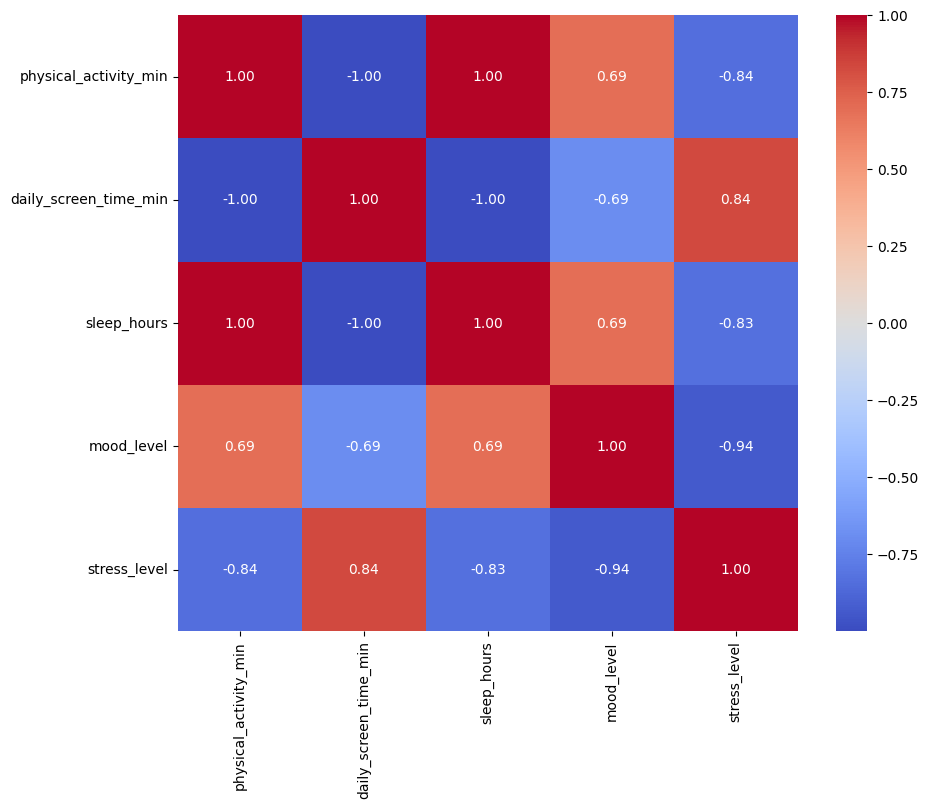

In [0]:
cols_to_corr = [
    "physical_activity_min",
    "daily_screen_time_min",
    "sleep_hours",
    "mood_level",
    "stress_level"
]
pdf = df.select(cols_to_corr).toPandas()

corr_matrix = pdf.corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.show()

Czas przed ekranem ma niemal idealną ujemną korelację z czasem snu (-1.00) i aktywnością fizyczną (-1.00) – im więcej ekranu, tym drastycznie mniej ruchu i snu.

Czas przed ekranem silnie wpływa na wzrost stresu (korelacja 0.84).

Dobry humor (mood_level) bardzo silnie obniża poziom stresu (-0.94).

In [0]:
df_days = df.withColumn("day_of_week", F.date_format(F.col("date"), "EEEE"))

day_stats = df_days.groupBy("day_of_week").agg(
    F.round(F.avg("daily_screen_time_min"), 2).alias("avg_screen_time")
).orderBy(F.desc("avg_screen_time"))

display(day_stats)

day_of_week,avg_screen_time
Monday,381.5
Tuesday,374.77
Saturday,373.12
Wednesday,372.63
Thursday,370.76
Sunday,369.54
Friday,368.97


Największe wykorzystanie ekranów przypada na poniedziałek (średnio 381.5 min), a najmniejsze na piątek (368.97 min).

In [0]:
df_age = df.withColumn("age_group", 
    F.when((F.col("age") >= 15) & (F.col("age") <= 20), "15-20")
     .when((F.col("age") > 20) & (F.col("age") <= 30), "21-30")
     .when((F.col("age") > 30) & (F.col("age") <= 40), "31-40")
     .when((F.col("age") > 40) & (F.col("age") <= 50), "41-50")
     .when((F.col("age") > 50) & (F.col("age") <= 60), "51-60")
     .when((F.col("age") > 60) & (F.col("age") <= 70), "61-70")
     .otherwise("71+")
)

In [0]:
age_lifestyle = df_age.groupBy("age_group").agg(
    F.round(F.avg("sleep_hours"), 2).alias("avg_sleep"),
    F.round(F.avg("stress_level"), 2).alias("avg_stress"),
    F.round(F.avg("physical_activity_min"), 2).alias("avg_activity"),
    F.round(F.avg("daily_screen_time_min"), 2).alias("avg_screen_time")
).orderBy("age_group")

display(age_lifestyle)

age_group,avg_sleep,avg_stress,avg_activity,avg_screen_time
15-20,6.73,7.82,14.67,453.55
21-30,6.81,7.63,16.18,438.11
31-40,7.4,6.63,28.02,319.82
41-50,7.87,5.84,37.22,227.52
51-60,8.11,5.52,42.06,179.27
61-70,8.1,5.49,41.97,180.28
71+,6.9,7.78,18.04,419.43


Zdecydowanie grupa 51-60 lat wiedzie najzdrowszy tryb życia. Osoby te mają najlepsze wyniki we wszystkich kategoriach: śpią najdłużej (8.11h), są najmniej zestresowane (5.52), mają najwyższą aktywność fizyczną (42.06 min) i spędzają najmniej czasu przed ekranem (179 min). Najgorzej pod tym względem wypada młodzież (15-20 lat).

In [0]:
toxicity_df = df.groupBy("platform").agg(
    F.sum("negative_interactions_count").alias("total_neg"),
    F.sum("positive_interactions_count").alias("total_pos")
).withColumn("toxicity_ratio", 
             F.round(F.col("total_neg") / (F.col("total_neg") + F.col("total_pos")) * 100, 2)
).orderBy(F.desc("toxicity_ratio"))

display(toxicity_df)

platform,total_neg,total_pos,toxicity_ratio
TikTok,1200,1576,43.23
Twitter,653,973,40.16
Facebook,503,867,36.72
Snapchat,594,1252,32.18
Instagram,583,1703,25.5
YouTube,659,2181,23.2
WhatsApp,129,625,17.11


**Ranking "Toksyczności" Platform** - Sama liczba interakcji to nie wszystko – kluczowy jest ich charakter.

TikTok (43.23%) oraz Twitter (40.16%) to najbardziej toksyczne środowiska, gdzie niemal co druga interakcja jest negatywna.

Dla kontrastu, YouTube mimo ogromnej popularności (dużo interakcji ogółem) utrzymuje niski wskaźnik toksyczności (23.2%), co sugeruje, że dłuższe formy wideo sprzyjają bardziej pozytywnym odbiorom niż krótkie "strzały" dopaminowe.

Najbezpieczniejszym miejscem jest WhatsApp (tylko 17.11% negatywnych interakcji), co wynika z zamkniętego charakteru komunikacji (rozmowa ze znajomymi, a nie publiczna arena).

In [0]:
user_segmentation = df.withColumn(
    "usage_segment",
    F.when(
        F.col("daily_screen_time_min") < 180, "Light User (<3h)"
    ).when(
        F.col("daily_screen_time_min") <= 360, "Moderate User (3-6h)"
    ).otherwise("Heavy User (>6h)")
).groupBy("usage_segment").agg(
    F.round(F.avg("stress_level"), 2).alias("avg_stress"),
    F.round(F.avg("mood_level"), 2).alias("avg_mood"),
    F.count("*").alias("user_count")
).orderBy("avg_stress")

display(user_segmentation)

usage_segment,avg_stress,avg_mood,user_count
Light User (<3h),5.34,6.66,247
Moderate User (3-6h),6.25,6.17,1730
Heavy User (>6h),7.74,5.23,3023


**Wpływ intensywności użytkowania (Heavy vs Light Users)**

Dane pokazują drastyczny spadek kondycji psychicznej wraz ze wzrostem czasu przed ekranem. Grupa "Heavy Users" (>6h dziennie) ma poziom stresu wyższy o blisko 45% (7.74 vs 5.34) w porównaniu do użytkowników korzystających z ekranów rzadko (<3h).

Alarmująca statystyka: Grupa "Heavy Users" jest najliczniejsza (3023 osoby vs 247 "Light Users"). Oznacza to, że większość badanej populacji jest w strefie wysokiego ryzyka zdrowotnego, poświęcając ponad 1/4 doby na ekrany.

In [0]:
user_segmentation.write.format("delta").mode("overwrite").saveAsTable("user_segmentation_stats")
print("Tabela 'user_segmentation_stats' zapisana pomyślnie.")

toxicity_df.write.format("delta").mode("overwrite").saveAsTable("platform_toxicity_stats")
print("Tabela 'platform_toxicity_stats' zapisana pomyślnie.")

age_lifestyle.write.format("delta").mode("overwrite").saveAsTable("age_lifestyle_stats")
print("Tabela 'age_lifestyle_stats' zapisana pomyślnie.")

Tabela 'user_segmentation_stats' zapisana pomyślnie.
Tabela 'platform_toxicity_stats' zapisana pomyślnie.
Tabela 'age_lifestyle_stats' zapisana pomyślnie.
